In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp

import ROOT 

Welcome to JupyROOT 6.26/10


# Problem 1

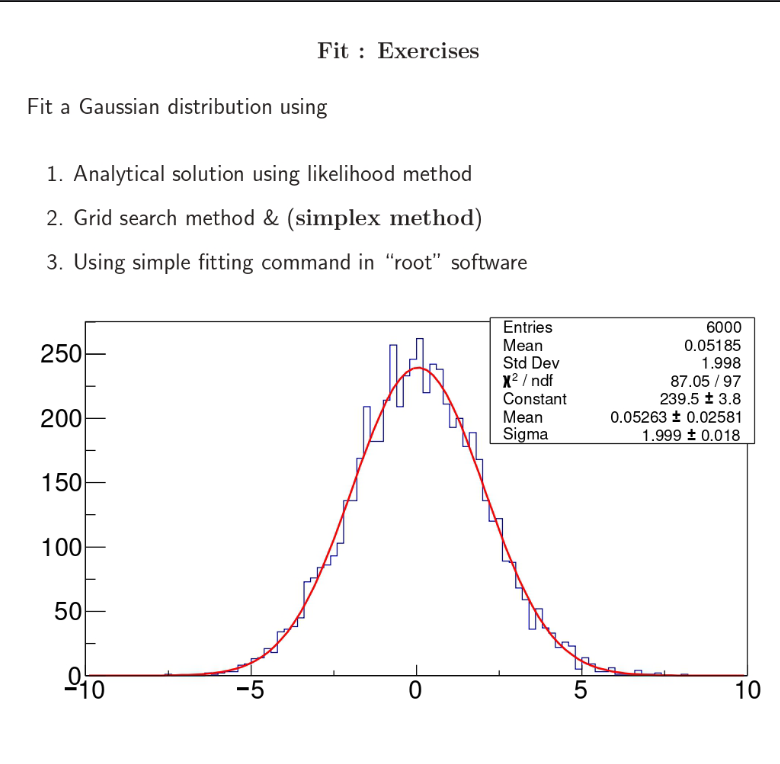

In [3]:
def chi2(Y,YTrue,YErr=None):
    if YErr is None:
        YErr = np.ones_like(YTrue)
    t_=(Y-YTrue)/YErr
    return np.sum(t_*t_)

## Generate Data

<ErrorbarContainer object of 3 artists>

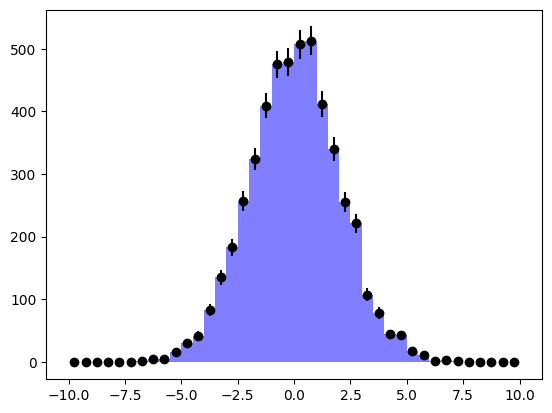

In [2]:
X=np.random.normal(scale=2,size=5000)
BW=0.5
c,b,_=plt.hist(X,bins=np.arange(-10.0,10.01,BW),color='b',alpha=0.5)
x_center=0.5*(b[:-1]+b[1:])
x_counts=c
x_counts_err=np.sqrt(x_counts)
x_counts_err[x_counts_err==0]=1e0
plt.errorbar(x_center,x_counts,x_counts_err,color='k',fmt='o')

## Analytical Expression

In [93]:
# MLE estimate of the mu / sigma / N
mean_g = np.mean(X)
sigma_g = np.std(X)
norm_g = len(X)*BW

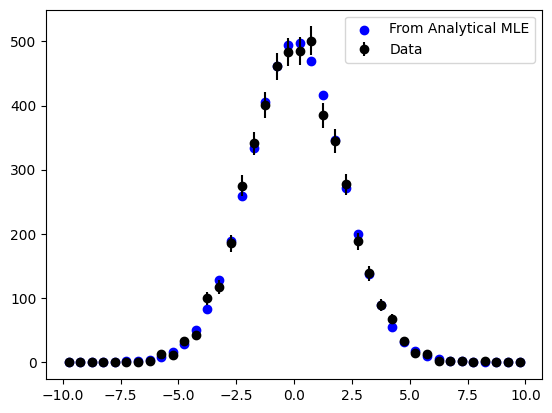

In [94]:
plt.scatter(x_center,norm_g*sp.stats.norm.pdf(x_center,loc=mean_g,scale=sigma_g),
            label='From Analytical MLE',color='b')
plt.errorbar(x_center,x_counts,x_counts_err,color='k',fmt='o',label='Data')
plt.legend()

## Grid Search 

##### Define Grid

In [23]:
def f_gauss(x,coeff):
    return coeff[0]*sc.stats.norm.pdf(x_center,loc=coeff[1],scale=coeff[2])

In [156]:
coeff=[10.0,0.1,3.0]

grid={
    'mu'    : np.arange(-3.0,3.0,0.05),
    'sigma' : np.arange(0.1,4.1,0.05),
}

mu_scan,sigma_scan=np.meshgrid(grid['mu'],grid['sigma'])
N_ITR=len(grid['mu'])*len(grid['sigma'])
print(f"{N_ITR}")

all_chi2=[]
all_mus=[]
all_sigmas=[]
i_count=0
for m in grid['mu']:
    for s in grid['sigma']:
        print(f"\rProcesing {i_count}/{N_ITR}",end="")
        i_count+=1
        y=f_gauss(x_center,[norm_g,m,s])
        chi2_val=chi2(y,x_counts,x_counts_err)
        all_chi2.append(chi2_val)
        all_mus.append(m)
        all_sigmas.append(s)
print()
            

min_idx=np.argmin(all_chi2)
print(f"{min_idx} | Chi2 = {all_chi2[min_idx]} for mu = {all_mus[min_idx]} , sigma = {all_sigmas[min_idx]}")

9600


Procesing 3110/9600

Procesing 4617/9600

Procesing 6156/9600

Procesing 8011/9600

Procesing 9548/9600

Procesing 9599/9600
4917 | Chi2 = 39.708939010657105 for mu = 0.049999999999989164 , sigma = 1.9500000000000006


In [154]:
# mu_scan,sigma_scan=np.meshgrid(grid['mu'],grid['sigma'])
# chi2_values=np.reshape(all_chi2,mu_scan.shape)

# plt.contour(mu_scan,sigma_scan,np.log(chi2_values))

## Muon Lifetime 

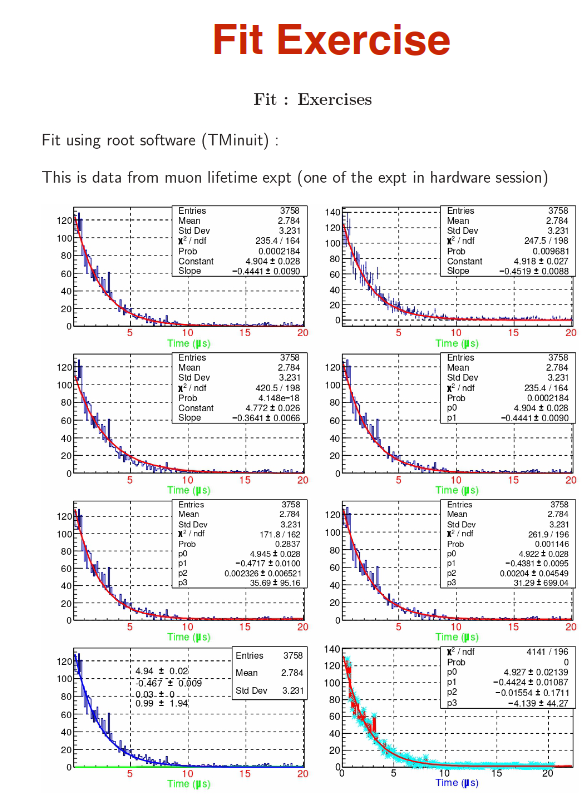

### Read data

In [4]:
data=[]
all_d=[]
with open('/home/aravind/Downloads/data1.txt') as f:
    txt=f.readlines()
    for l in txt:
        val = float(l[:-1].split()[1])*0.1
        all_d.append(val)
        if val > 0:
            data.append( val )
data=np.array(data)
all_d=np.array(all_d)

[]

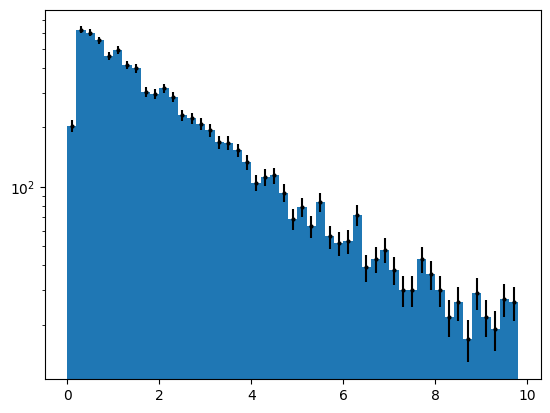

In [5]:
c,b,_=plt.hist(data,bins=np.arange(0.0,10.0,0.2))
deltaT = 0.5*(b[:-1]+b[1:])
deltaT_counts = c
deltaT_counts_err =np.sqrt(c)
plt.errorbar(deltaT,deltaT_counts,deltaT_counts_err,color='k',fmt='o',markersize=2)
plt.semilogy()

## Using ROOT

In [41]:
histogram=ROOT.TH1F("lifetime","Muon Lifetime",100,0.0,10.0)

Warning in <TROOT::Append>: Replacing existing TH1: lifetime (Potential memory leak).


In [42]:
for x in data:
    histogram.Fill(x)

In [44]:
fit_func=ROOT.TF1("exponential_ranged","[0]*exp([1]*x)",0.1,10.0);

In [45]:
histfit_rslt_v2=histogram.Fit(fit_func,"SR")

 FCN=228.799 FROM MIGRAD    STATUS=CONVERGED     300 CALLS         301 TOTAL
                     EDM=8.13321e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.31449e+02   5.83317e+00   2.80114e-02  -1.03932e-05
   2  p1          -4.07500e-01   5.63514e-03   2.70537e-05  -7.94172e-02


In [46]:
vals=histfit_rslt_v2.GetParams()
print("exp_slope = ",vals[1],"  | mu_lifelite  = ",-1.0/vals[1])

exp_slope =  -0.40750005592569233   | mu_lifelite  =  2.4539873932737573


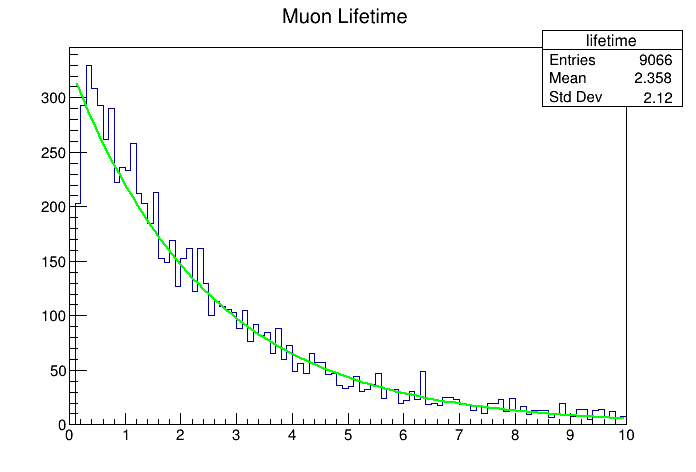

In [47]:
cv=ROOT.TCanvas()
histogram.Draw()
fit_func.SetLineColor(ROOT.kGreen)
fit_func.Draw("same")
cv.Draw()

## Using TMinuit

In [7]:
minimizer = ROOT.Math.Factory.CreateMinimizer("Minuit2", "SIMPLEX")

## set tolerance , etc...
minimizer.SetMaxFunctionCalls(1000000); # for Minuit/Minuit2
minimizer.SetMaxIterations(10000);  # for GSL
minimizer.SetTolerance(0.001);
minimizer.SetPrintLevel(1);

In [9]:
def f_exp(x,coeff):
    return coeff[0]*np.exp(coeff[1]*x )
    

In [10]:
mask= np.logical_and( deltaT >= 0.5 , deltaT < 6.0 )

deltaT_ =deltaT[mask]
deltaT_counts_=deltaT_counts[mask]
deltaT_counts_err_=deltaT_counts_err[mask]

def chi2ForMinimizer(coeff):
    y=f_exp(deltaT_,coeff)
    c=chi2(y,deltaT_counts_,deltaT_counts_err_)
    return c

In [11]:
cff=[100.0,-0.3]
y=f_exp(deltaT,cff)
print(chi2(y,deltaT_counts))
# plt.scatter(deltaT,y)

1803084.6463315838


In [12]:
func_proc=ROOT.Math.Functor(chi2ForMinimizer,2)

minimizer.SetFunction(func_proc)

minimizer.SetVariable(0,"n",5000.0, 0.8)
minimizer.SetVariable(1,"b",1.0, 0.01)

In [353]:
# def func(x):
#     return x[0]*x[0]-7*x[0]+12

# func_proc=ROOT.Math.Functor(func,2)

In [15]:
minimizer.Minimize()

True

Minuit2Minimizer: Minimize with max-calls 1000000 convergence for edm < 0.001 strategy 1
Minuit2Minimizer : Valid minimum - status = 5
FVAL  = 33.8929347316807323
Edm   = 6.17832490803493783e-05
Nfcn  = 144
n	  = 738.001	 +/-  31.0226
b	  = -0.443692	 +/-  0.0158208


Warning in <Minuit2>: Minuit2Minimizer::Minimize Covar is not pos def


In [23]:
# minimizer.PrintResults()
x=minimizer.X()
mu_lft = -1.0/x[1]
print("N = ",x[0]," b = ",x[1]," | mu_lifetime = ",-1.0/x[1])

N =  738.0005813050967  b =  -0.44369247175447113  | mu_lifetime =  2.253813313635342


In [17]:
coeffs_minuit=[ x[i] for i in range(2)]

In [20]:
y=f_exp(deltaT,coeffs_minuit)

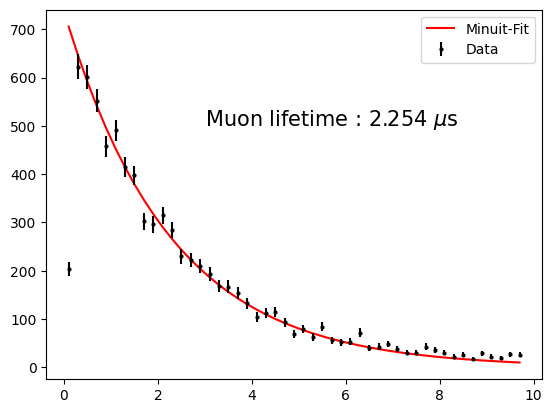

In [27]:
plt.plot(deltaT,y,color='r',label='Minuit-Fit')
plt.errorbar(deltaT,deltaT_counts,deltaT_counts_err,color='k',fmt='o',markersize=2,label='Data')
plt.text(3,500,f"Muon lifetime : {mu_lft:.3f} "+"$\mu$s",fontsize=15)
plt.legend()

# Multiple Histogram Fits

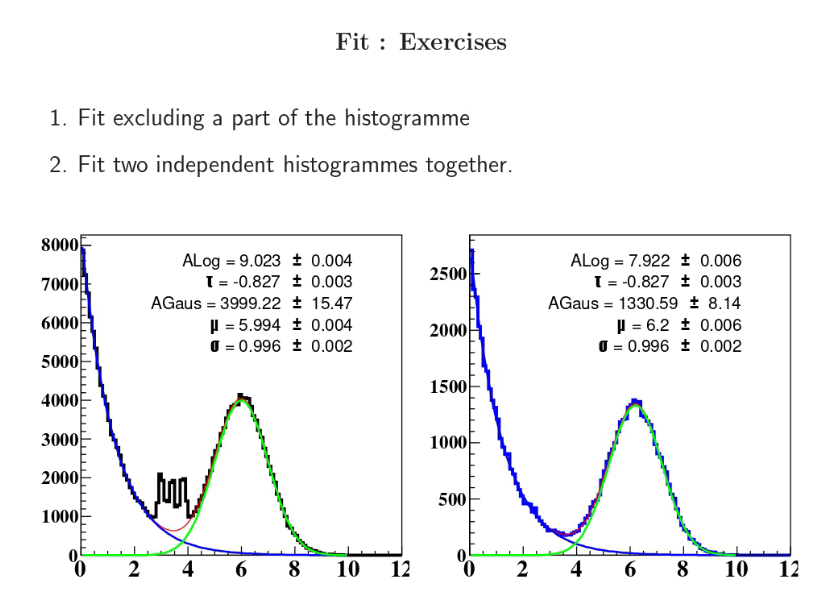

#### Read and Store the data from the Histogram

In [252]:
filein=ROOT.TFile('/home/aravind/Downloads/expoplusgaus.root')

h1=filein.Get('histx')
h2=filein.Get('histy')

data1_x=[]
data1_y=[]
data1_yerr=[]
for i in range(1,h1.GetNbinsX()+1):
    #print(i,h1.GetBinCenter(i),h1.GetBinContent(i),h1.GetBinError(i))
    data1_x.append(h1.GetBinCenter(i) )
    data1_y.append(h1.GetBinContent(i) )
    data1_yerr.append(h1.GetBinError(i) )
data1_x=np.array(data1_x)
data1_y=np.array(data1_y)
data1_yerr=np.array(data1_yerr)
data1_yerr[data1_yerr==0] =1.0

data2_x=[]
data2_y=[]
data2_yerr=[]
for i in range(1,h2.GetNbinsX()+1):
    #print(i,h2.GetBinCenter(i),h2.GetBinContent(i),h2.GetBinError(i))
    data2_x.append(h2.GetBinCenter(i) )
    data2_y.append(h2.GetBinContent(i) )
    data2_yerr.append(h2.GetBinError(i) )
data2_x=np.array(data2_x)
data2_y=np.array(data2_y)
data2_yerr=np.array(data2_yerr)
data2_yerr[data2_yerr==0] =1.0

##### Plotting the values once !

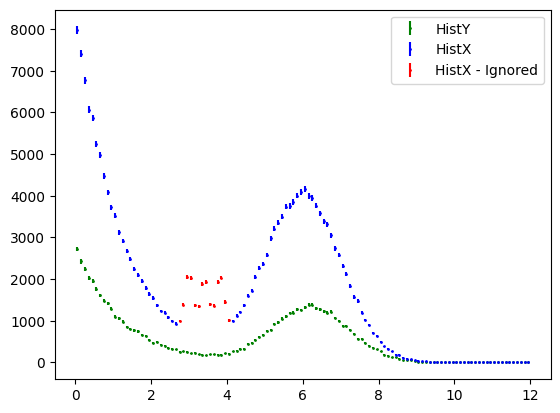

In [185]:
plt.errorbar(data2_x,data2_y,data2_yerr,fmt='o',color='g',markersize=1,label='HistY')
mask1 = np.logical_or(data1_x < 2.7 ,data1_x > 4.1)
plt.errorbar(data1_x[mask1],data1_y[mask1],data1_yerr[mask1],
             fmt='o',color='b',markersize=1,label='HistX')
mask1 = np.logical_not(mask1)
plt.errorbar(data1_x[mask1],data1_y[mask1],data1_yerr[mask1],
             fmt='o',color='r',markersize=1,label='HistX - Ignored')
plt.legend()

##### Defenition of the fit funtions

In [199]:
def f_expGauss(x,n0,b,n1,mu,sigma):
    return n0*np.exp(b*x)+n1*np.exp(-1*(x-mu)*(x-mu)/2.0/sigma/sigma)

#### Defenition of the Chi2 funtion to minimize

In [253]:
mask = np.logical_or(data1_x < 2.7 ,data1_x > 4.1)

data1_x_ =data1_x[mask]
data1_y_ =data1_y[mask]
data1_yerr_=data1_yerr[mask]

mask =  np.abs(data2_x) > -1
data2_x_ =data2_x[mask]
data2_y_ =data2_y[mask]
data2_yerr_=data2_yerr[mask]

def chi2ForMinimizer_h1h2(coeff):
    #  [h1_n0,b,h1_n1,h1_mu,h1_sigma ,h2_n0, h2_n1 , h2_mu ]
    #
    chi2_1 = 0.0
    y1 = f_expGauss(data1_x_,coeff[0],coeff[1],coeff[2],coeff[3],coeff[4])
    y2 = f_expGauss(data2_x_,coeff[5],coeff[1],coeff[6],coeff[7],coeff[4])
    
    return chi2(y1,data1_y_,data1_yerr_) + chi2(y2,data2_y_,data2_yerr_)
    
### SAMPLE PLOTTER FUNCTION
def plotTest(coeff):
    #  [h1_n0,b,h1_n1,h1_mu,h1_sigma ,h2_n0, h2_n1 , h2_mu ]
    #
    chi2_1 = 0.0
    y1 = f_expGauss(data1_x_,coeff[0],coeff[1],coeff[2],coeff[3],coeff[4])
    y2 = f_expGauss(data2_x_,coeff[5],coeff[1],coeff[6],coeff[7],coeff[4])
    plt.scatter(data1_x_,y1,color='c',alpha=0.2)
    plt.scatter(data2_x_,y2,color='lime',alpha=0.2)

In [ ]:
# coeffs=np.array([ 1e3 , -0.9, 2e3, 6.0,2.0, 6e3,4e3,8.0])
# for i in range(10):
#     cf = np.random.uniform(size=len(coeffs))*coeffs
#     print(chi2ForMinimizer_h1h2(cf))

#### Derivation of the Minimizer

In [241]:
minimizer = ROOT.Math.Factory.CreateMinimizer("Minuit2", "MIDGRAD")
## set tolerance , etc...
minimizer.SetMaxFunctionCalls(1000000); # for Minuit/Minuit2
minimizer.SetMaxIterations(1090000);  # for GSL
minimizer.SetTolerance(0.001);
minimizer.SetPrintLevel(1);

In [242]:
func_proc=ROOT.Math.Functor(chi2ForMinimizer_h1h2,8)
minimizer.SetFunction(func_proc)

In [243]:
minimizer.SetVariable(0,"h1_n1",9000.0, 0.8)
minimizer.SetVariable(1,"b",-0.4, 0.01)
minimizer.SetVariable(2,"h1_n2",4e3, 0.9)
minimizer.SetVariable(3,"h1_mu",6.0, 0.01)
minimizer.SetVariable(4,"sigma",2.0, 0.01)
minimizer.SetVariable(5,"h2_n1",3000.0, 0.8)
minimizer.SetVariable(6,"h2_n2",1000.0, 0.8)
minimizer.SetVariable(7,"h2_mu",6.0, 0.01)

True

In [244]:
minimizer.Minimize()

True

Minuit2Minimizer: Minimize with max-calls 1000000 convergence for edm < 0.001 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 196.204103917094244
Edm   = 3.78398030286762529e-07
Nfcn  = 658
h1_n1	  = 8365.59	 +/-  39.7109
b	  = -0.839364	 +/-  0.00383148
h1_n2	  = 3989.69	 +/-  15.3564
h1_mu	  = 5.99689	 +/-  0.00374497
sigma	  = 1.00075	 +/-  0.00256465
h2_n1	  = 2789.66	 +/-  19.0062
h2_n2	  = 1329.34	 +/-  7.99922
h2_mu	  = 6.19049	 +/-  0.00600644


In [246]:
x=minimizer.X()

In [247]:
cf=[x[i] for i in range(8)]

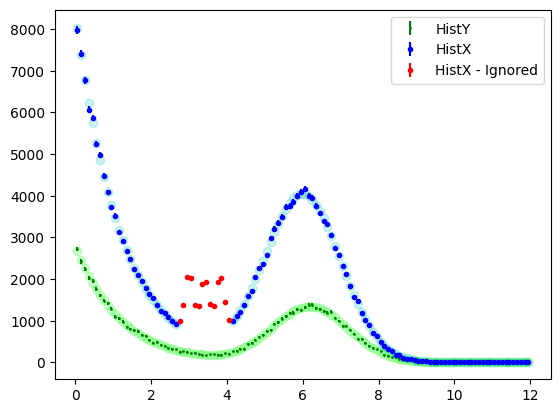

In [250]:
plotTest(cf)
plt.errorbar(data2_x,data2_y,data2_yerr,fmt='o',color='g',markersize=1,label='HistY')
mask1 = np.logical_or(data1_x < 2.7 ,data1_x > 4.1)
plt.errorbar(data1_x[mask1],data1_y[mask1],data1_yerr[mask1],
             fmt='o',color='b',markersize=3,label='HistX')
mask1 = np.logical_not(mask1)
plt.errorbar(data1_x[mask1],data1_y[mask1],data1_yerr[mask1],
             fmt='o',color='r',markersize=3,label='HistX - Ignored')
plt.legend()